<a href="https://colab.research.google.com/github/ashutoshsinha25/Coursera_Projects/blob/main/Superhero_Name_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Superhero and Supervillain name generator

Data and Tokenizer
1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [1]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [2]:
with open('/content/superhero/superheroes.txt' , 'r') as f:
  data = f.read()

data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [5]:
tokenizer.fit_on_texts(data)

In [6]:
char_to_index = tokenizer.word_index
index_to_char = dict((v , k) for k ,v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


Names and Sequences
1. Converting between names ans sequences

In [7]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [8]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [9]:
def name_to_seq(names):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in names ]

In [10]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [11]:
def seq_to_name(seq):
  return [''.join([index_to_char[i] for i in seq if i!=0])]

In [12]:
seq_to_name(name_to_seq(names[0]))

['jumpa\t']

Creating Examples
1. Creating sequences
2. adding all sequences

In [13]:
sequences = []
for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2:
    sequences += [seq[:i] for i in range(2 , len(seq) + 1)]

In [14]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [15]:
max_len = max([len(x) for x in sequences])
print(max_len)

33


In [16]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences , padding = 'pre', maxlen = max_len
)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [17]:
padded_sequences.shape

(88279, 33)

Training and Validation set
1. Creating training and validation set

In [18]:
x , y = padded_sequences[: , :-1] , padded_sequences[: , -1]
print(x.shape , y.shape)

(88279, 32) (88279,)


In [19]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(x , y)


print(X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

(66209, 32) (22070, 32)
(66209,) (22070,)


In [20]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars)

29


Creating a model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , Conv1D , MaxPool1D , LSTM
from tensorflow.keras.layers import Bidirectional  , Dense 

In [22]:
model = Sequential([
               Embedding(num_chars , 8 , input_length = max_len-1),
               Conv1D(64, 5 , strides = 1 , activation ='tanh', padding ='causal'),
               MaxPool1D(2),
               LSTM(32),
               Dense(num_chars , activation = 'softmax')   
])


model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
____________________________________________________

Training the model

In [23]:
history = model.fit(X_train , y_train,
                    validation_data = (X_test , y_test),
                    epochs = 50,
                    verbose = 2,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 3)])

Epoch 1/50
2070/2070 - 29s - loss: 2.7617 - accuracy: 0.1863 - val_loss: 2.5683 - val_accuracy: 0.2347 - 29s/epoch - 14ms/step
Epoch 2/50
2070/2070 - 11s - loss: 2.5297 - accuracy: 0.2402 - val_loss: 2.4839 - val_accuracy: 0.2561 - 11s/epoch - 5ms/step
Epoch 3/50
2070/2070 - 10s - loss: 2.4606 - accuracy: 0.2598 - val_loss: 2.4328 - val_accuracy: 0.2743 - 10s/epoch - 5ms/step
Epoch 4/50
2070/2070 - 10s - loss: 2.4117 - accuracy: 0.2741 - val_loss: 2.3981 - val_accuracy: 0.2788 - 10s/epoch - 5ms/step
Epoch 5/50
2070/2070 - 10s - loss: 2.3739 - accuracy: 0.2839 - val_loss: 2.3675 - val_accuracy: 0.2902 - 10s/epoch - 5ms/step
Epoch 6/50
2070/2070 - 11s - loss: 2.3412 - accuracy: 0.2937 - val_loss: 2.3444 - val_accuracy: 0.2936 - 11s/epoch - 5ms/step
Epoch 7/50
2070/2070 - 10s - loss: 2.3130 - accuracy: 0.3014 - val_loss: 2.3241 - val_accuracy: 0.3005 - 10s/epoch - 5ms/step
Epoch 8/50
2070/2070 - 12s - loss: 2.2869 - accuracy: 0.3081 - val_loss: 2.3052 - val_accuracy: 0.3075 - 12s/epoch - 

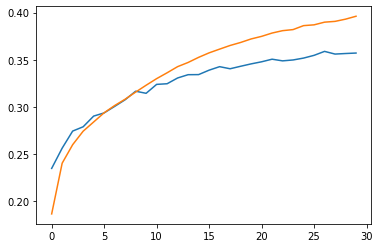

In [27]:
import matplotlib.pyplot as plt 
%matplotlib inline
epochs_ran = len(history.history['loss'])

plt.plot(range(0 , epochs_ran) , history.history['val_accuracy'] , label = 'validation')
plt.plot(range(0 , epochs_ran) , history.history['accuracy'] , label = 'training')
plt.show()

Generating names

In [30]:
def generate_names(seed):
  for i in range(0 , 40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq] , 
                                                          padding = 'pre' ,
                                                          maxlen = max_len - 1,
                                                          truncating = 'pre')
    
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break
  print(seed)

In [33]:
generate_names('z')

zark	
